## FOOTBALL PLAYER V/S GROUND SEGMENTATION

In [ ]:
import json
import cv2
import numpy as np
import os

IMAGE_DIR = "D:\DEEP_LEARNING_A\CV\footballdata\images"
MASK_DIR = r"D:\DEEP_LEARNING_A\CV\footballdata\annotations"
os.makedirs(MASK_DIR, exist_ok=True)

with open("instances_default.json") as f:
    data = json.load(f)

id_to_filename = {img['id']: img['file_name'] for img in data['images']}

annotations = data['annotations']

# Create mask for each image
for img in data['images']:
    mask = np.zeros((img['height'], img['width']), dtype=np.uint8)
    
    # Find all annotations for this image
    anns = [a for a in annotations if a['image_id'] == img['id']]
    
    for a in anns:
        category_id = a['category_id']
        for seg in a['segmentation']:
            # COCO segmentation is a list of x,y coordinates flattened
            pts = np.array(seg, dtype=np.int32).reshape(-1, 2)
            cv2.fillPoly(mask, [pts], category_id)
    
    # Save mask
    mask_filename = os.path.join(MASK_DIR, img['file_name'])
    cv2.imwrite(mask_filename, mask)


In [ ]:
import os
import cv2
import numpy as np

IMAGE_DIR = r"D:\DEEP_LEARNING_A\CV\footballdata\images"
MASK_DIR = r"D:\DEEP_LEARNING_A\CV\footballdata\annotations"

IMG_HEIGHT, IMG_WIDTH = 512, 512

# Load images
image_files = sorted(os.listdir(IMAGE_DIR))
mask_files = sorted(os.listdir(MASK_DIR))

images = []
masks = []

for img_file, mask_file in zip(image_files, mask_files):
    # Load and resize image
    img = cv2.imread(os.path.join(IMAGE_DIR, img_file))
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0  
    images.append(img)

    # Load and resize mask
    mask = cv2.imread(os.path.join(MASK_DIR, mask_file), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    masks.append(mask)

images = np.array(images)  
masks = np.array(masks)    
print("Images:", images.shape, "Masks:", masks.shape)


Images: (512, 512, 512, 3) Masks: (512, 512, 512)


In [2]:
print(np.unique(masks))


[0 1 2]


In [3]:
from tensorflow.keras.utils import to_categorical

NUM_CLASSES = 3  # background=0, person=1
masks_onehot = to_categorical(masks, num_classes=NUM_CLASSES)
print("Masks one-hot shape:", masks_onehot.shape)

Masks one-hot shape: (512, 512, 512, 3)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam


def unet_model(input_size=(512,512,3), num_classes=3):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64,3,activation='relu',padding='same')(inputs)
    c1 = Conv2D(64,3,activation='relu',padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(128,3,activation='relu',padding='same')(p1)
    c2 = Conv2D(128,3,activation='relu',padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    # Bottleneck
    c3 = Conv2D(256,3,activation='relu',padding='same')(p2)
    c3 = Conv2D(256,3,activation='relu',padding='same')(c3)

    # Decoder
    u4 = Conv2DTranspose(128,2,strides=2,padding='same')(c3)
    u4 = concatenate([u4,c2])
    c4 = Conv2D(128,3,activation='relu',padding='same')(u4)
    c4 = Conv2D(128,3,activation='relu',padding='same')(c4)

    u5 = Conv2DTranspose(64,2,strides=2,padding='same')(c4)
    u5 = concatenate([u5,c1])
    c5 = Conv2D(64,3,activation='relu',padding='same')(u5)
    c5 = Conv2D(64,3,activation='relu',padding='same')(c5)

    # Output layer
    outputs = Conv2D(num_classes, 1, activation='softmax')(c5)

    return Model(inputs, outputs)

In [ ]:
NUM_CLASSES = 3  
model = unet_model(input_size=(512,512,3), num_classes=NUM_CLASSES)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 256, 256,  │    131,200 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 256, 256,  │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 256, 256,  │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 512, 512,  │     32,832 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512, 512,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 512, 512,  │     73,792 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 512, 512,  │     36,928 │ conv2d_8[0][0]  

 Total params: 1,862,979 (7.11 MB)

 Trainable params: 1,862,979 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    images,            
    masks_onehot,      
    batch_size=4,
    epochs=2,
    validation_split=0.1
)

Epoch 1/2
115/115 ━━━━━━━━━━━━━━━━━━━━ 3690s 32s/step - accuracy: 0.9715 - loss: 0.2674 - val_accuracy: 0.9835 - val_loss: 0.0932
Epoch 2/2
115/115 ━━━━━━━━━━━━━━━━━━━━ 2462s 21s/step - accuracy: 0.9810 - loss: 0.0759 - val_accuracy: 0.9861 - val_loss: 0.0320


In [ ]:
test_img = images[0:1]  
pred_mask = model.predict(test_img)

# Convert softmax output to class indices
segmented = np.argmax(pred_mask[0], axis=-1)  

1/1 ━━━━━━━━━━━━━━━━━━━━ 114s 114s/step


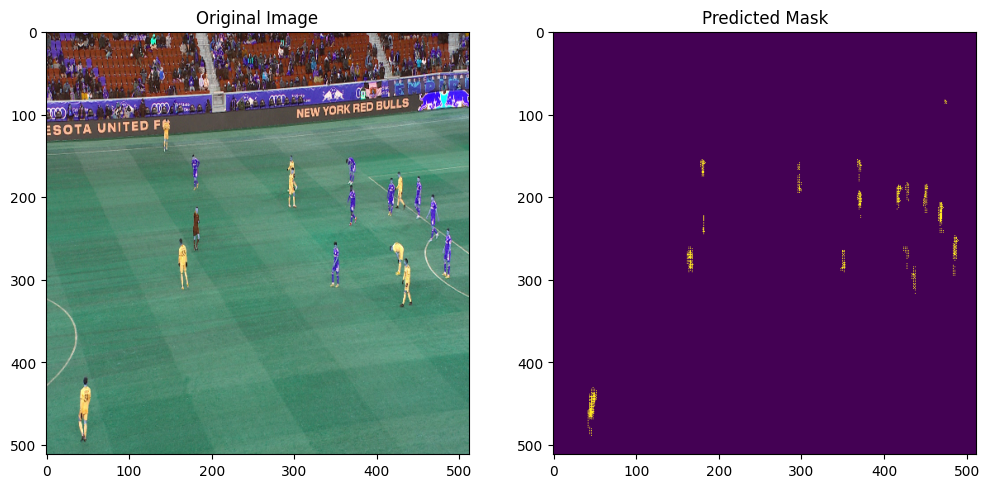

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(images[0])
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(segmented)
plt.title("Predicted Mask")
plt.show()

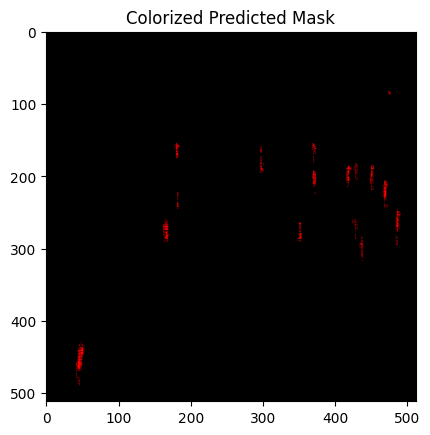

In [ ]:
colors = np.array([
    [0,0,0],      # background = black
    [255,0,0],    # person = red
    [0,255,0]     # other object = green
])

color_mask = colors[segmented]  
plt.imshow(color_mask)
plt.title("Colorized Predicted Mask")
plt.show()

In [17]:
test_img = images[32:33]  # shape (1,512,512,3)
pred_mask = model.predict(test_img)

# Convert softmax output to class indices
segmented = np.argmax(pred_mask[0], axis=-1) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 105s 105s/step


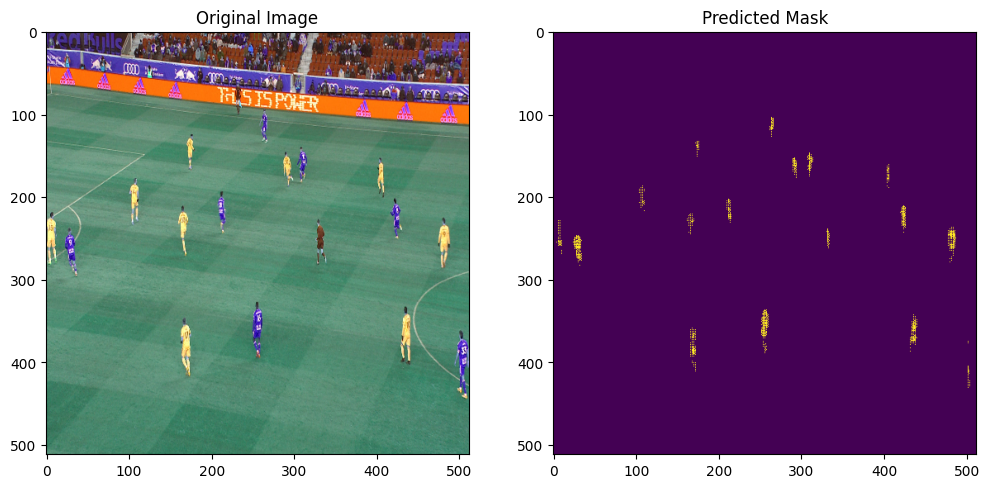

In [19]:
# Display original image and predicted mask
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(images[32])
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(segmented)
plt.title("Predicted Mask")
plt.show()